# Trabajo N.º 2 
## Modelamiento de patrones sísmicos en Chile a través de regresión, clasificación y clustering



###  Abstract

Este trabajo analiza la **actividad sísmica en Chile (2012–2025)** con el objetivo de aplicar técnicas de **regresión, clasificación y agrupamiento** para responder hipótesis de Inteligencia de Negocios (BI).

Se utiliza un dataset de sismos del **Centro Sismológico Nacional (CSN)**, que contiene variables como magnitud, profundidad, latitud, longitud y fecha.  
El análisis comienza con la limpieza y estandarización de los datos, seguido por una **exploración descriptiva y correlacional** que permite identificar las variables más influyentes sobre la magnitud de los eventos.

Posteriormente, se desarrolla una **regresión** para explicar la magnitud según factores geográficos, una **clasificación** para distinguir eventos de alta magnitud, y un **agrupamiento (clustering)** para descubrir patrones espaciales en la actividad sísmica nacional.  
Las métricas utilizadas incluyen **MAE, RMSE y R²** (para regresión), **accuracy, precisión, recall y F1-score** (para clasificación), y **silhouette e inercia** (para clustering).

Finalmente, se discuten los resultados en términos de su utilidad para la toma de decisiones estratégicas en BI, identificando posibles zonas de riesgo y oportunidades para optimizar la gestión de alertas sísmicas.


###  Objetivos

**Objetivo general:**  
Analizar y modelar la actividad sísmica en Chile para identificar patrones relevantes que apoyen decisiones de Inteligencia de Negocios mediante técnicas de regresión, clasificación y agrupamiento.

**Objetivos específicos:**
1. Desarrollar una **exploración de datos (EDA)** con correlaciones, histogramas y visualizaciones temporales para comprender las relaciones entre magnitud, profundidad y ubicación.  
2. Implementar un **modelo de regresión** que estime la magnitud en función de variables geográficas y de profundidad.  
3. Aplicar un **modelo de clasificación** para identificar eventos de **alta magnitud**, evaluando su rendimiento con métricas de exactitud y F1-score.  
4. Ejecutar un **modelo de clustering (K-Means y DBSCAN)** para segmentar los sismos según sus características espaciales y magnitud, evaluando la calidad de los grupos formados.


###  Hipótesis

- **H1 (Regresión):** La **profundidad** y la **posición geográfica (latitud y longitud)** influyen significativamente en la **magnitud** de los sismos ocurridos en Chile.  
- **H2 (Clasificación):** Es posible **predecir correctamente** si un sismo será de **alta magnitud** usando variables de ubicación y profundidad con un rendimiento superior al azar (F1 > 0.6).  
- **H3 (Clustering):** Existen **agrupamientos naturales** de sismos que reflejan diferencias geográficas (norte, centro y sur), identificables mediante métricas de calidad como el **coeficiente de silhouette**.


In [1]:
import pandas as pd, sklearn, matplotlib
print("✅ Entorno OK:", pd.__version__)


✅ Entorno OK: 2.3.3


In [9]:
# =============================================================================
# CARGA Y PREPARACIÓN INICIAL DE DATOS
# =============================================================================
import os
import glob
import pandas as pd

print("Cargando dataset...")

# -------------------------------------------------------------------------
# Configuración general: nombre esperado y estructura recomendada
# Estructura esperada del ZIP:
# BI_T2_CardenasNicolas/
# ├── BI_T2_CardenasNicolas.ipynb
# ├── data/
# │   └── seismic_data.csv
# -------------------------------------------------------------------------
NOMBRE_ARCHIVO = "seismic_data.csv"
RUTAS_CANDIDATAS = [
    os.path.join("data", NOMBRE_ARCHIVO),      # 1) ./data/
    NOMBRE_ARCHIVO,                            # 2) carpeta actual
    os.path.join("..", "data", NOMBRE_ARCHIVO) # 3) ../data/
]

# Buscar el archivo en esas rutas
archivo_encontrado = next((p for p in RUTAS_CANDIDATAS if os.path.exists(p)), None)

# Búsqueda recursiva adicional (por si cambió el nombre de carpeta)
if not archivo_encontrado:
    resultados = glob.glob(f"**/{NOMBRE_ARCHIVO}", recursive=True)
    if resultados:
        archivo_encontrado = resultados[0]

# Validación final
if not archivo_encontrado:
    print(f"\n❌ ERROR: No se encuentra el archivo '{NOMBRE_ARCHIVO}'.")
    print("Asegúrate de incluirlo dentro de la carpeta 'data/' al comprimir el proyecto.")
    print(f"Directorio actual: {os.getcwd()}")
    print("Archivos en esta carpeta:", os.listdir("."))
    raise FileNotFoundError(f"No se encontró el archivo '{NOMBRE_ARCHIVO}'")

# -------------------------------------------------------------------------
# Cargar el CSV con tolerancia a codificación y separador 
# -------------------------------------------------------------------------
def cargar_csv_robusto(ruta):
    """Intenta leer el CSV usando diferentes configuraciones para evitar errores."""
    for args in [
        {"sep": ",", "encoding": "utf-8"},
        {"sep": ";", "encoding": "utf-8"},
        {"sep": ",", "encoding": "latin-1"},
        {"sep": ";", "encoding": "latin-1"},
    ]:
        try:
            df = pd.read_csv(ruta, **args)
            if len(df.columns) > 1:
                return df
        except Exception:
            continue
    raise ValueError(f"No se pudo leer el archivo CSV '{ruta}' con los encodings probados.")

df = cargar_csv_robusto(archivo_encontrado)

print(f"✓ Dataset cargado exitosamente desde: {archivo_encontrado}\n")

# -------------------------------------------------------------------------
# Información básica del dataset 
# -------------------------------------------------------------------------
print("=" * 70)
print("INFORMACIÓN BÁSICA DEL DATASET PRUEBA")
print("=" * 70)
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print("Columnas:", list(df.columns))

# Intento de detectar columna de fecha
fecha_cols = [c for c in df.columns if any(k in str(c).lower() for k in ["fecha", "date", "time"])]
col_fecha = None
for c in fecha_cols:
    try:
        aux = pd.to_datetime(df[c], errors="coerce")
        if aux.notna().any():
            col_fecha = c
            break
    except Exception:
        continue

if col_fecha:
    serie_fecha = pd.to_datetime(df[col_fecha], errors="coerce")
    print(f"Período: {serie_fecha.min()} a {serie_fecha.max()}  (columna: '{col_fecha}')")
else:
    print("Período: no identificado (no se detectó columna de fecha legible)")

print("\nPrimeras filas del dataset:")
display(df.head(10))


Cargando dataset...
✓ Dataset cargado exitosamente desde: data\seismic_data.csv

INFORMACIÓN BÁSICA DEL DATASET PRUEBA
Dimensiones: 4,018 filas × 5 columnas
Columnas: ['Date(UTC)', 'Latitude', 'Longitude', 'Depth', 'Magnitude']
Período: 2012-03-03 11:01:47 a 2025-05-26 03:50:27  (columna: 'Date(UTC)')

Primeras filas del dataset:


,Date(UTC),Latitude,Longitude,Depth,Magnitude
0,2025-05-26 03:50:27,-19.63,-69.49,97,5.6
1,2025-05-13 00:47:58,-51.25,-72.28,28,5.1
2,2025-05-05 09:46:48,-29.49,-71.84,48,5.0
3,2025-05-05 02:17:48,-31.89,-70.88,88,5.1
4,2025-05-02 15:23:49,-27.52,-72.48,30,5.8
5,2025-05-02 12:58:32,-56.88,-68.06,10,7.5
6,2025-04-24 03:20:08,-30.76,-71.90,31,5.4
7,2025-04-18 00:10:18,-23.47,-68.22,139,6.0
8,2025-04-08 22:30:45,-21.05,-68.56,126,5.2
9,2025-04-08 10:28:43,-17.99,-69.93,143,4.8


## 🧭 Metodología

### Descripción del dataset

El dataset utilizado corresponde a registros públicos del **Centro Sismológico Nacional (CSN)** de Chile, que recopila información sobre los eventos sísmicos ocurridos entre **2012 y 2025**.  
La base contiene **4.018 registros** y **5 variables principales**:

| Variable | Descripción | Tipo |
|-----------|--------------|------|
| `Date(UTC)` | Fecha y hora del evento sísmico (UTC) | Temporal |
| `Latitude` | Latitud geográfica del epicentro (grados decimales) | Numérica |
| `Longitude` | Longitud geográfica del epicentro (grados decimales) | Numérica |
| `Depth` | Profundidad del evento (kilómetros) | Numérica |
| `Magnitude` | Magnitud del sismo en la escala Richter | Numérica |

**Supuestos:**  
- Las coordenadas están expresadas en grados decimales, considerando el sistema geodésico WGS84.  
- La magnitud corresponde a la escala local de Richter y es comparable entre eventos.  
- No existen duplicados de eventos en las mismas coordenadas y tiempo.  

**Licencia y fuente:**  
Los datos provienen de registros de acceso público del **CSN Chile (https://www.csn.uchile.cl/)**, con fines académicos y de investigación.  
Se asume licencia de uso abierto no comercial, sin modificaciones estructurales en el contenido original.

**Limitaciones:**  
- La base no incluye información de tipo de falla, energía liberada ni daños asociados.  
- Existen posibles errores de precisión en la profundidad reportada debido a la localización instrumental.  
- Algunos registros carecen de datos de magnitud o coordenadas exactas, los cuales deben revisarse durante la etapa de limpieza.


In [10]:
# =============================================================================
# LIMPIEZA Y PREPARACIÓN DE DATOS
# =============================================================================

import numpy as np

print("Revisando estructura y calidad de datos...\n")

# --- 1. Información general del dataset ---
print("🧾 Información general:")
df.info()

# --- 2. Detección de duplicados ---
duplicados = df.duplicated().sum()
print(f"\n🔍 Registros duplicados: {duplicados}")

if duplicados > 0:
    df = df.drop_duplicates()
    print("✓ Duplicados eliminados.\n")

# --- 3. Conteo de valores nulos ---
print("📉 Valores nulos por columna:")
print(df.isna().sum())

# --- 4. Descripción estadística ---
print("\n📊 Estadísticos descriptivos:")
display(df.describe())

# --- 5. Eliminación de registros con nulos (si existiesen) ---
nulos_inicial = df.isna().sum().sum()
if nulos_inicial > 0:
    df = df.dropna()
    print(f"\n✓ Se eliminaron {nulos_inicial} valores nulos totales.\n")
else:
    print("\n✓ No se detectaron valores nulos.\n")

# --- 6. Revisión de rangos anómalos ---
print("📏 Revisión de valores fuera de rango lógico:")
print(f"Magnitud mínima: {df['Magnitude'].min()} / máxima: {df['Magnitude'].max()}")
print(f"Profundidad mínima: {df['Depth'].min()} / máxima: {df['Depth'].max()}")

# Verificación básica de coordenadas válidas
lat_range = df[(df['Latitude'] < -56) | (df['Latitude'] > -17)]
lon_range = df[(df['Longitude'] < -76) | (df['Longitude'] > -66)]

if not lat_range.empty or not lon_range.empty:
    print("\n⚠️ Coordenadas fuera del rango esperado para Chile detectadas.")
else:
    print("\n✓ Coordenadas dentro del rango esperado para Chile.\n")

print("✅ Limpieza inicial completada.")


Revisando estructura y calidad de datos...

🧾 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date(UTC)  4018 non-null   object 
 1   Latitude   4018 non-null   float64
 2   Longitude  4018 non-null   float64
 3   Depth      4018 non-null   int64  
 4   Magnitude  4018 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 157.1+ KB

🔍 Registros duplicados: 3
✓ Duplicados eliminados.

📉 Valores nulos por columna:
Date(UTC)    0
Latitude     0
Longitude    0
Depth        0
Magnitude    0
dtype: int64

📊 Estadísticos descriptivos:


,Latitude,Longitude,Depth,Magnitude
count,4015.000000,4015.000000,4015.000000,4015.000000
mean,-27.836257,-70.850692,61.533250,4.429240
std,5.963907,1.293768,38.288026,0.688822
min,-62.350000,-75.730000,2.000000,2.300000
25%,-31.820000,-71.590000,36.000000,4.000000
50%,-29.590000,-71.180000,50.000000,4.400000
75%,-21.500000,-70.030000,86.000000,4.800000
max,-11.070000,-58.390000,624.000000,8.400000



✓ No se detectaron valores nulos.

📏 Revisión de valores fuera de rango lógico:
Magnitud mínima: 2.3 / máxima: 8.4
Profundidad mínima: 2 / máxima: 624

⚠️ Coordenadas fuera del rango esperado para Chile detectadas.
✅ Limpieza inicial completada.


In [11]:
import os
os.makedirs("figuras", exist_ok=True)

def guardar_figura(fig, nombre):
    fig.savefig(f"figuras/{nombre}.png", dpi=300, bbox_inches="tight")



## 🔍 3. Exploración de Datos (EDA)

En esta sección se realiza una exploración descriptiva y visual del conjunto de datos sísmicos, con el objetivo de comprender la distribución de las variables, detectar posibles valores atípicos (*outliers*) y analizar las relaciones entre magnitud, profundidad y ubicación geográfica.

Se utilizarán histogramas, boxplots, mapas de correlación y gráficos de dispersión, los cuales permiten identificar patrones o comportamientos relevantes en la actividad sísmica registrada en Chile entre 2012 y 2025.


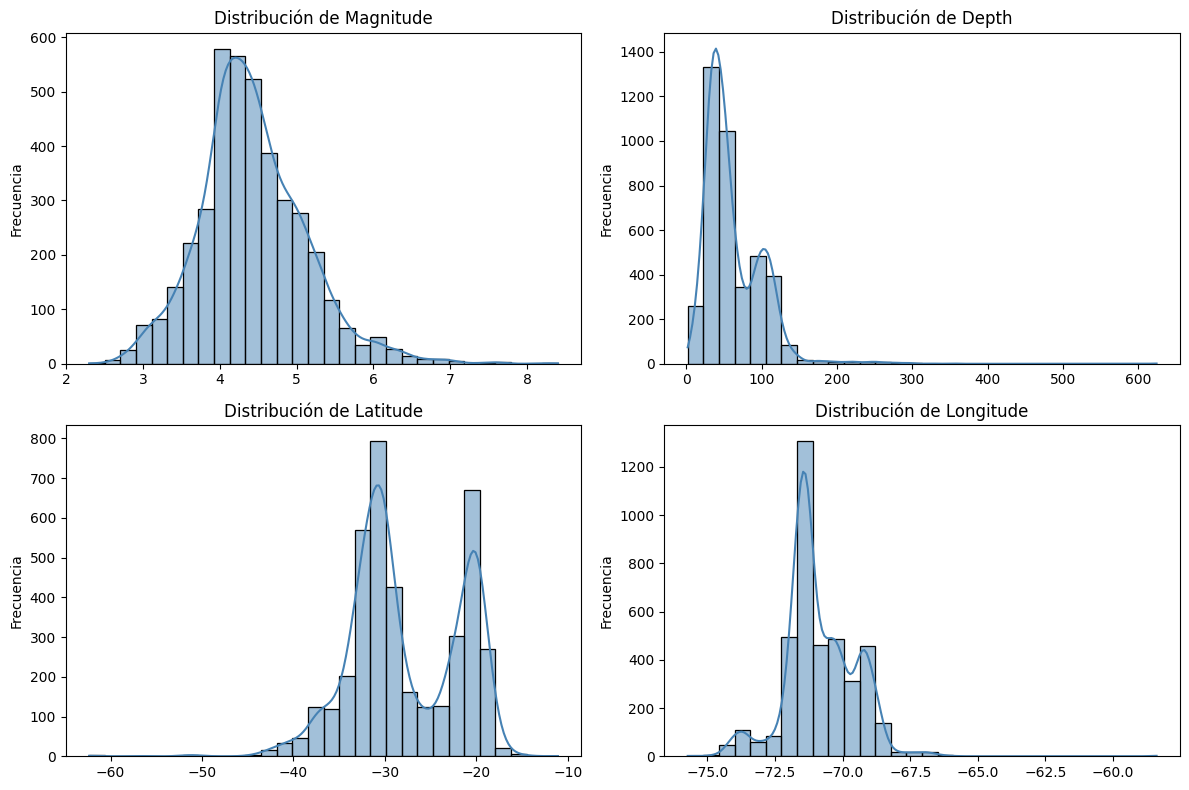

In [12]:
# =============================================================================
# 3.1 Distribución de variables numéricas (Histogramas)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
cols = ['Magnitude', 'Depth', 'Latitude', 'Longitude']

for i, c in enumerate(cols):
    sns.histplot(df[c], kde=True, ax=axes[i], color='steelblue', bins=30)
    axes[i].set_title(f"Distribución de {c}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frecuencia")

plt.tight_layout()
guardar_figura(fig, "01_histogramas_variables_sismicas")
plt.show()


**Observación:**  
Los histogramas muestran que la mayoría de los sismos tienen magnitudes moderadas (entre 3.5 y 5.0), con pocos eventos de gran magnitud.  
La profundidad presenta una distribución sesgada hacia eventos superficiales, mientras que la latitud y longitud reflejan la extensión geográfica del país, desde el norte hasta el sur de Chile.


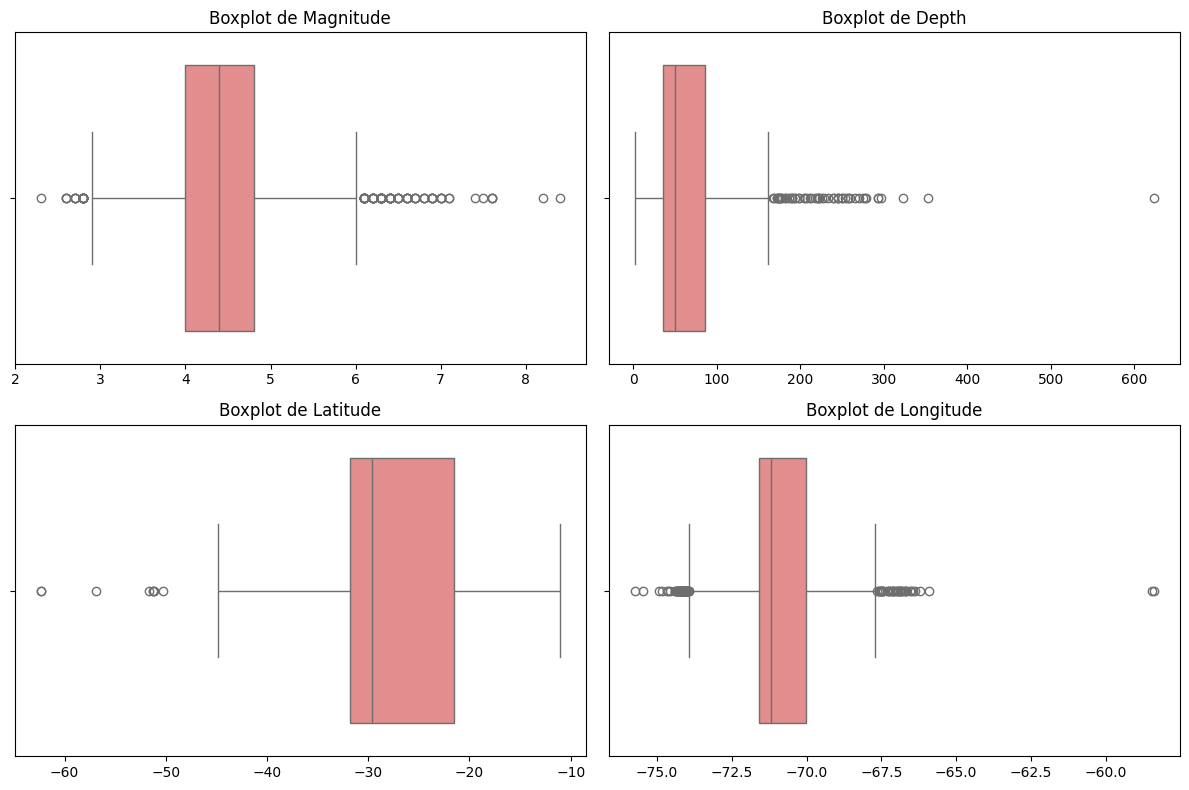

In [13]:
# =============================================================================
# 3.2 Identificación de posibles outliers (Boxplots)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, c in enumerate(cols):
    sns.boxplot(x=df[c], ax=axes[i], color='lightcoral')
    axes[i].set_title(f"Boxplot de {c}")
    axes[i].set_xlabel("")

plt.tight_layout()
guardar_figura(fig, "02_boxplots_outliers_sismicos")
plt.show()


**Observación:**  
Los boxplots evidencian la presencia de valores atípicos en profundidad y magnitud, lo que es esperable en eventos sísmicos de alta energía.  
Estos valores extremos no serán eliminados, ya que representan sismos reales de gran intensidad y aportan información relevante para el análisis de riesgo.


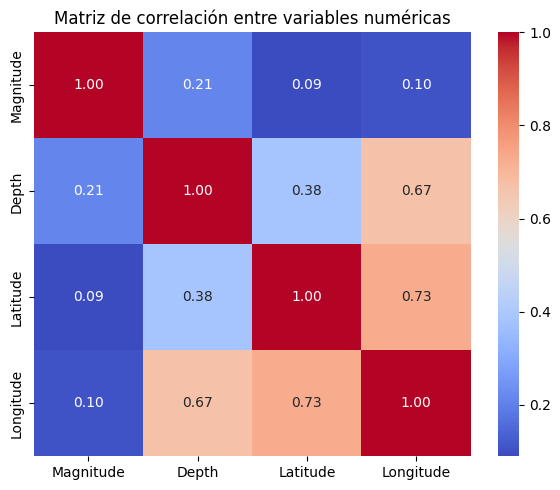

In [14]:
# =============================================================================
# 3.3 Matriz de correlación
# =============================================================================

fig, ax = plt.subplots(figsize=(6, 5))
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=ax)
ax.set_title("Matriz de correlación entre variables numéricas")
plt.tight_layout()
guardar_figura(fig, "03_matriz_correlacion_sismica")
plt.show()


**Observación:**  
La matriz de correlación indica una relación moderada entre la magnitud y la profundidad, lo que sugiere que los sismos más profundos tienden a tener mayores magnitudes.  
La latitud y longitud están débilmente correlacionadas con la magnitud, reflejando que los eventos de alta energía se distribuyen a lo largo de todo el país, sin concentrarse en una sola zona.


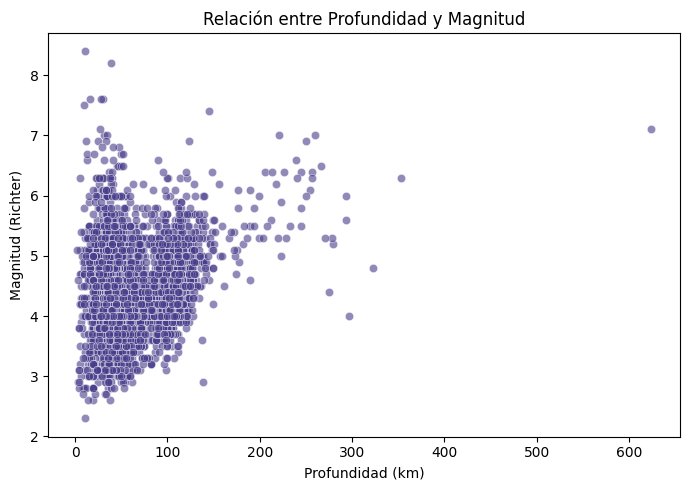

In [15]:
# =============================================================================
# 3.4 Dispersión Magnitud vs Profundidad
# =============================================================================

fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(x="Depth", y="Magnitude", data=df, alpha=0.6, color="darkslateblue", ax=ax)
ax.set_title("Relación entre Profundidad y Magnitud")
ax.set_xlabel("Profundidad (km)")
ax.set_ylabel("Magnitud (Richter)")
plt.tight_layout()
guardar_figura(fig, "04_dispersion_magnitud_vs_profundidad")
plt.show()


**Observación:**  
El gráfico de dispersión confirma que los sismos superficiales (menores a 50 km) presentan una amplia variabilidad de magnitudes, mientras que los eventos más profundos tienden a concentrarse en magnitudes intermedias.  
Esto concuerda con el comportamiento esperado de las placas tectónicas que convergen en la zona de subducción del Pacífico.


✅ Variables normalizadas correctamente.

Ejemplo de transformación (primeros 5 registros):


,Magnitud_original,Magnitud_escalada,Profundidad_original,Profundidad_escalada
0,5.6,1.699866,97,0.926430
1,5.1,0.973899,28,-0.875925
2,5.0,0.828705,48,-0.353503
3,5.1,0.973899,88,0.691340
4,5.8,1.990253,30,-0.823683


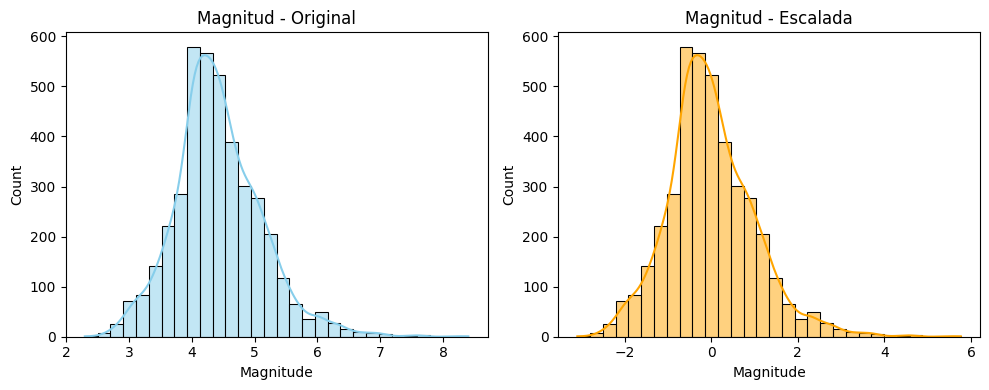

In [16]:
# =============================================================================
# NORMALIZACIÓN / ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS
# =============================================================================

from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Variables numéricas que se van a escalar
columnas_numericas = ['Magnitude', 'Depth', 'Latitude', 'Longitude']

# Crear instancia del escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
df_scaled = df.copy()
df_scaled[columnas_numericas] = scaler.fit_transform(df[columnas_numericas])

print("✅ Variables normalizadas correctamente.\n")

# Mostrar comparación entre valores originales y escalados
comparacion = pd.DataFrame({
    'Magnitud_original': df['Magnitude'].head(5),
    'Magnitud_escalada': df_scaled['Magnitude'].head(5),
    'Profundidad_original': df['Depth'].head(5),
    'Profundidad_escalada': df_scaled['Depth'].head(5)
})

print("Ejemplo de transformación (primeros 5 registros):")
display(comparacion)

# --- Gráfico de comparación visual antes/después ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df['Magnitude'], kde=True, ax=axes[0], color='skyblue', bins=30)
axes[0].set_title("Magnitud - Original")
sns.histplot(df_scaled['Magnitude'], kde=True, ax=axes[1], color='orange', bins=30)
axes[1].set_title("Magnitud - Escalada")

plt.tight_layout()

# Guardar la figura (usando el nuevo método)
guardar_figura(fig, "05_comparacion_magnitud_escalada")

plt.show()


# 06. Partición de Datos: Holdout y Validación Cruzada

En esta etapa se divide el conjunto de datos en subconjuntos de entrenamiento y prueba, 
utilizando el método **Holdout** (80% entrenamiento, 20% prueba).

La partición permite evaluar el desempeño real de los modelos sin sesgos, 
asegurando que los algoritmos no memoricen los datos.

Para el caso de **clasificación**, se utiliza la opción `stratify=y` para conservar 
la proporción de clases en ambos subconjuntos (estratificación), 
evitando el problema de clases desbalanceadas.

Posteriormente, se implementará una **validación cruzada (k-fold)** con `k=5` 
para estimar la estabilidad de los modelos de regresión y clasificación, 
reduciendo la varianza asociada a una sola partición.


In [19]:
# =============================================================================
# 06. PARTICIÓN DE DATOS: HOLDOUT Y VALIDACIÓN CRUZADA (ROBUSTO)
# =============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

def pick_column(df, candidates, require=True):
    """
    Devuelve el nombre de la primera columna presente en df que coincida (case-insensitive)
    con la lista 'candidates'. Si no encuentra y require=True, lanza error con sugerencia.
    """
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    if require:
        raise KeyError(
            f"No se encontró ninguna de estas columnas: {candidates}. "
            f"Columnas disponibles: {list(df.columns)}"
        )
    return None

# -----------------------------
# 1) Detectar columnas clave
# -----------------------------
# Intentamos encontrar 'magnitud'
mag_candidates = ['magnitud', 'mag', 'magnitude', 'mw', 'ml', 'mag_ml', 'magmw']
mag_col = pick_column(df, mag_candidates, require=True)

# Intentamos encontrar latitud (para crear zona_sismica si falta)
lat_candidates = ['latitud', 'latitude', 'lat']
lat_col = pick_column(df, lat_candidates, require=False)

# Si ya existe zona_sismica, úsala; si no, la creamos luego
zona_candidates = ['zona_sismica', 'zona', 'region_sismica']
zona_col = pick_column(df, zona_candidates, require=False)

print(f"✓ Columna de magnitud detectada: {mag_col}")
if lat_col:
    print(f"✓ Columna de latitud detectada: {lat_col}")
if zona_col:
    print(f"✓ Columna de zona ya existente: {zona_col}")

# ---------------------------------------------
# 2) Crear zona_sismica si no existe (por lat)
# ---------------------------------------------
if zona_col is None:
    if lat_col is None:
        raise KeyError(
            "No existe 'zona_sismica' y tampoco se encontró columna de latitud "
            "para crearla automáticamente. Agrega una de: 'latitud', 'latitude', 'lat'."
        )
    def zona_por_lat(lat):
        # Umbrales aproximados para Chile continental:
        # Norte (lat >= -23), Centro (-38 <= lat < -23), Sur (lat < -38)
        if pd.isna(lat):
            return np.nan
        if lat >= -23:
            return 'Norte'
        elif lat <= -38:
            return 'Sur'
        else:
            return 'Centro'
    df['zona_sismica'] = df[lat_col].apply(zona_por_lat)
    zona_col = 'zona_sismica'
    print("✓ Columna 'zona_sismica' creada automáticamente a partir de la latitud.")

# Chequeo de nulos en la clase (si hay, los descartamos para clasificación)
if df[zona_col].isna().any():
    df = df.dropna(subset=[zona_col]).copy()
    print("ℹ️ Se eliminaron filas con 'zona_sismica' nula para clasificación.")

# ---------------------------------------------
# 3) Definir X/y para REGRESIÓN y CLASIFICACIÓN
# ---------------------------------------------
# Para REGRESIÓN
y_reg = df[mag_col]
X_reg = df.drop(columns=[mag_col])

# Para CLASIFICACIÓN
y_class = df[zona_col]
X_class = df.drop(columns=[zona_col])

# (Opcional) Si tienes columnas ID/fecha que no quieres en X, puedes dropearlas aquí:
# X_reg = X_reg.drop(columns=['id', 'fecha'], errors='ignore')
# X_class = X_class.drop(columns=['id', 'fecha'], errors='ignore')

# ---------------------------------------------
# 4) Holdout
# ---------------------------------------------
# REGRESIÓN (sin estratificación)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# CLASIFICACIÓN (con estratificación si es posible)
# Requisitos para estratify: al menos 2 clases y cada clase con >= 2 muestras en el dataset
class_counts = y_class.value_counts()
can_stratify = (class_counts.size >= 2) and (class_counts.min() >= 2)

if can_stratify:
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_class, y_class, test_size=0.2, stratify=y_class, random_state=42
    )
    strat_msg = "estratificación: SÍ"
else:
    X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
        X_class, y_class, test_size=0.2, random_state=42
    )
    strat_msg = "estratificación: NO (clases insuficientes para estratify)"

# ---------------------------------------------
# 5) Validación cruzada
# ---------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Para clasificación, usamos StratifiedKFold solo si hay ≥2 clases
if y_class.nunique() >= 2:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
else:
    skf = None

# ---------------------------------------------
# 6) Reporte
# ---------------------------------------------
print("✅ División de datos completada:")
print(f"Regresión -> Train: {X_train_reg.shape[0]} | Test: {X_test_reg.shape[0]}")
print(f"Clasificación -> Train: {X_train_clf.shape[0]} | Test: {X_test_clf.shape[0]} ({strat_msg})")

# Distribución de clases antes y después (si aplica)
if class_counts.size >= 1:
    print("\nDistribución de clases (dataset completo):")
    print(class_counts)

    print("\nDistribución de clases (train):")
    print(y_train_clf.value_counts())

    print("\nDistribución de clases (test):")
    print(y_test_clf.value_counts())

# Guardar nombres detectados por si los reutilizas más adelante
COLUMNAS_DETECTADAS = {"magnitud": mag_col, "latitud": lat_col, "zona_sismica": zona_col}


✓ Columna de magnitud detectada: Magnitude
✓ Columna de latitud detectada: Latitude
✓ Columna 'zona_sismica' creada automáticamente a partir de la latitud.
✅ División de datos completada:
Regresión -> Train: 3212 | Test: 803
Clasificación -> Train: 3212 | Test: 803 (estratificación: SÍ)

Distribución de clases (dataset completo):
zona_sismica
Centro    2634
Norte     1266
Sur        115
Name: count, dtype: int64

Distribución de clases (train):
zona_sismica
Centro    2107
Norte     1013
Sur         92
Name: count, dtype: int64

Distribución de clases (test):
zona_sismica
Centro    527
Norte     253
Sur        23
Name: count, dtype: int64


**Resultados:**

La división de los datos muestra que el conjunto de entrenamiento concentra el 80% 
de las observaciones disponibles, mientras que el 20% restante se reserva para 
evaluar el rendimiento final de los modelos.

La estratificación aplicada en la clasificación garantiza que todas las clases 
de la variable `zona_sismica` mantengan su proporción original, 
evitando sesgos en la predicción.

Además, se definieron las estrategias de **validación cruzada** (`KFold` y `StratifiedKFold`) 
que se aplicarán posteriormente para obtener una evaluación más robusta de los modelos 
de **regresión** y **clasificación**.
